# Sætter partier og regioner ind i G og rewriter filen

In [1]:
import networkx as nx
import pickle
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
import re
from fa2 import ForceAtlas2


In [2]:
data=pd.read_csv("danish_politkere_twitter2.csv")

In [3]:
data.groupby('Party').count()

,Names,Twittername,Region
Party,,,
Alternativet,4,4,4
Dansk Folkeparti,21,21,21
Det Konservative Folkeparti,22,22,22
Enhedslisten,23,23,23
Government,14,14,14
Inuit Ataqatigiit,1,1,1
Liberal Alliance,7,7,7
Nye Borgerlige,4,4,4
Radikale Venstre,26,26,26


In [4]:
len(data.index)

651

In [58]:
G = nx.read_gpickle("second_network_w_weights_listversion_wrealnames_v2.gpickle")

In [59]:
G.number_of_nodes()

561

In [60]:
def pre_check():
    nodes = G.nodes()
    count=0
    to_remove = [] 
    for node in nodes:
        if node in data.values:
            count+=1
        else:
            print(node + " will be removed")
            to_remove.append(node)
    for node in to_remove:
        G.remove_node(node)
    return len(to_remove)

print("Removing " +str(pre_check()) + " nodes")

Birgitte2012 will be removed
MFVMin will be removed
SassLarsen will be removed
AsgerChristens2 will be removed
Martin_geertsen will be removed
Removing 5 nodes


In [61]:
G.number_of_nodes()

556

In [62]:
dict_of_attributes = {}
for node in G.nodes():
    #print(node)
    x = data.loc[data['Twittername'] == node]
    #print(x)
    party =  x.values[0][2]
    region = x.values[0][3]
    #print(node, party, region)
    attribute = {'party': party, 'region': region}
    dict_of_attributes[node] = attribute
nx.set_node_attributes(G, dict_of_attributes)

 ## Yikes on amount of unknowns
Some googles show a lot of "Byråd / kommunalbestyrelsen"

# Count links betweeen parties

## with unknowns

In [63]:
parties = list(nx.get_node_attributes(G,'party').values())
#G.nodes(data=True)

In [64]:
politicians=list(G.nodes)
unique_parties = set(parties)

In [65]:
tweet_to_count = {}
tweet_out_count = {}


for party in unique_parties:
    tweet_to_count[party] = 0
    tweet_out_count[party] = 0


In [66]:
#print(parties)

In [67]:
# party in + out degrees
print("edges (mentions): " + str(G.number_of_edges()))
for edge in G.edges():
    _from = edge[0]
    _to = edge[1]
    _to_party = parties[politicians.index(_to)]
    _out_party = parties[politicians.index(_from)]
    
    
    tweet_to_count[_to_party] += 1
    tweet_out_count[_out_party] += 1

    
tweet_to_count = dict(sorted(tweet_to_count.items(), key=lambda item: item[1], reverse=True))
tweet_out_count = dict(sorted(tweet_out_count.items(), key=lambda item: item[1],reverse=True))


edges (mentions): 10263


# Visualizations

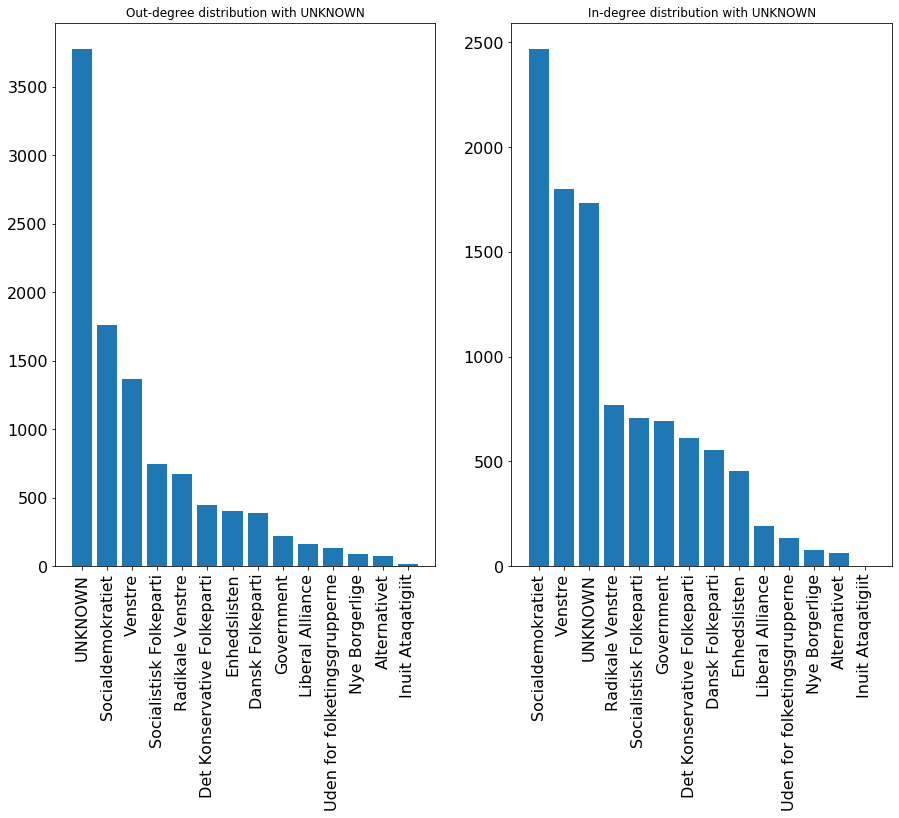

In [68]:
import matplotlib.pyplot as plt
import seaborn as sns
fig = plt.subplots(figsize=(15,10))
plt.subplot(1, 2, 1)
plt.tick_params(labelsize=16)
plt.xticks(rotation=90)
plt.bar(tweet_out_count.keys(), tweet_out_count.values())
plt.title("Out-degree distribution with UNKNOWN")

plt.subplot(1, 2, 2)
plt.tick_params(labelsize=16)
plt.xticks(rotation=90)
plt.bar(tweet_to_count.keys(), tweet_to_count.values())
plt.title("In-degree distribution with UNKNOWN")
plt.show()

## Without unknowns

In [69]:

tweet_to_count_clean = tweet_to_count.copy()
tweet_out_count_clean = tweet_out_count.copy()

tweet_to_count_clean.pop('UNKNOWN')
tweet_out_count_clean.pop('UNKNOWN')


3778

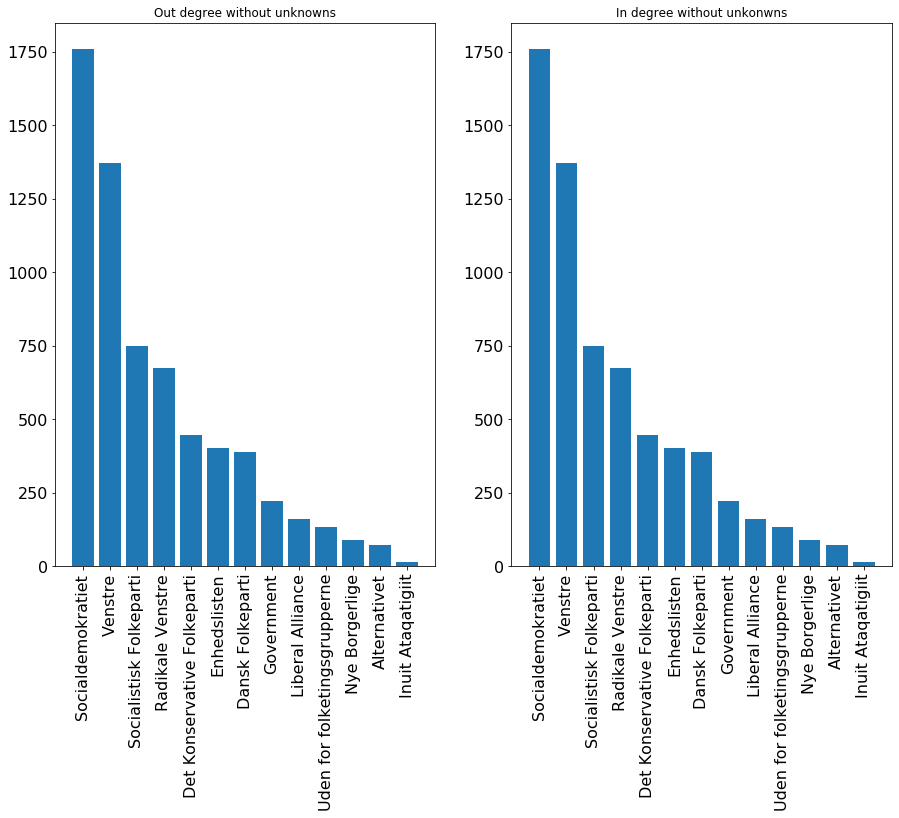

In [70]:
fig = plt.subplots(figsize=(15,10))

plt.subplot(1,2,1)
plt.tick_params(labelsize=16)
plt.xticks(rotation=90)
plt.bar(tweet_out_count_clean.keys(), tweet_out_count_clean.values())
plt.title("Out degree without unknowns")

plt.subplot(1,2,2)
plt.tick_params(labelsize=16)
plt.xticks(rotation=90)
plt.bar(tweet_out_count_clean.keys(), tweet_out_count_clean.values())
plt.title("In degree without unkonwns")
plt.show()


## Getting average as the amount of policians isn't at all evenly distributed

In [71]:
vals = nx.get_node_attributes(G, "party").values()
sum_party =dict.fromkeys(tweet_out_count.keys(),0)
for party_occ in vals:
    sum_party[party_occ] += 1
sum_party

avg_tweet_out = dict.fromkeys(tweet_out_count.keys())
avg_tweet_in= dict.fromkeys(tweet_to_count.keys())

for key in tweet_out_count:
    avg_tweet_out[key] = tweet_out_count[key] / sum_party[key]
    avg_tweet_in[key] = tweet_to_count[key] / sum_party[key]
    
ang_tweet_out = dict(sorted(avg_tweet_out.items(), key=lambda item: item[1],reverse=True))
avg_tweet_in = dict(sorted(avg_tweet_in.items(), key=lambda item: item[1],reverse=True))


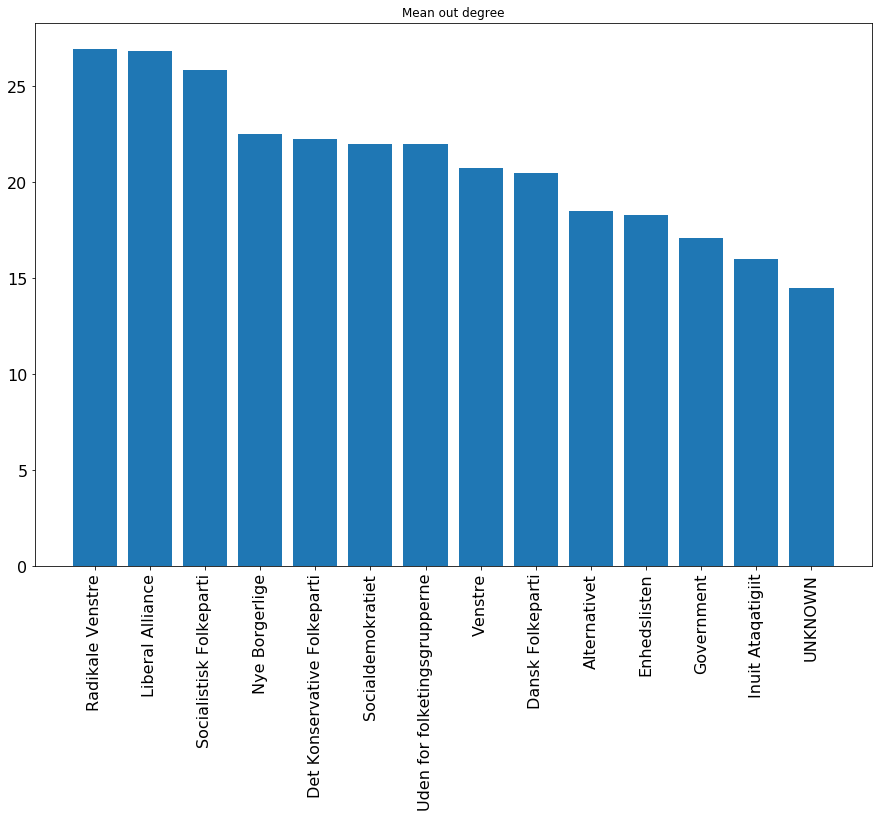

In [72]:
#ax = plt.subplot(111)

#x = pd.DataFrame([avg_tweet_in])
#chart =sns.barplot(x="day", y="total_bill",data=x)
#chart.set_xticklabels(chart.get_xticklabels(), rotation=90)
#plt.show()
fig = plt.subplots(figsize=(15,10))

plt.tick_params(labelsize=16)
plt.xticks(rotation=90)
plt.bar(ang_tweet_out.keys(), ang_tweet_out.values())
plt.title("Mean out degree")
plt.show()

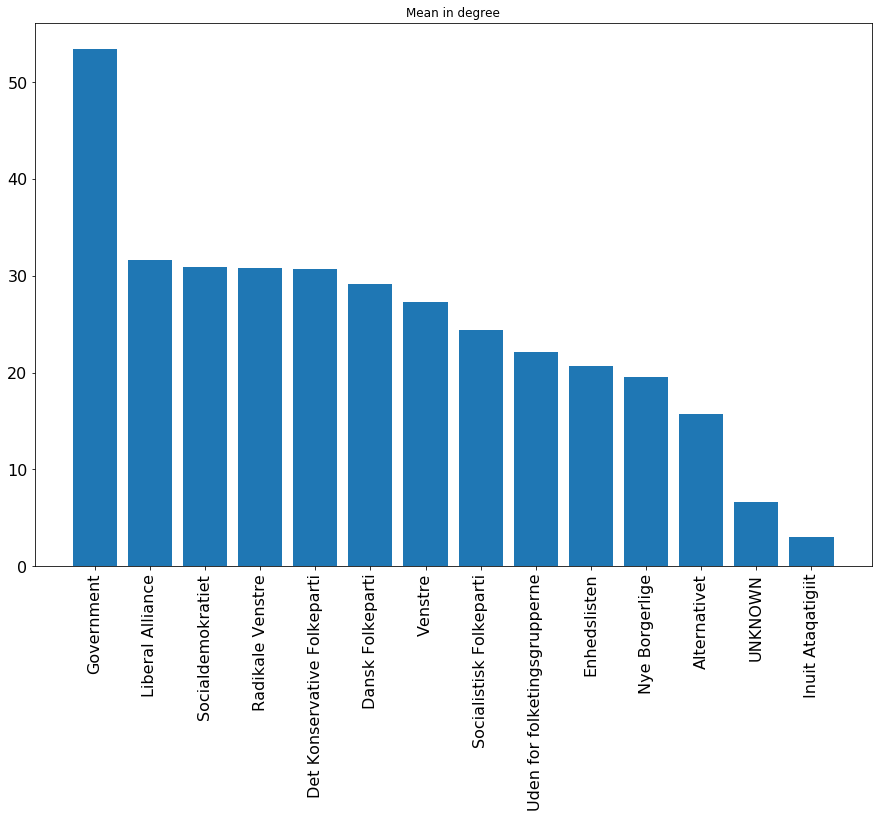

In [73]:
fig = plt.subplots(figsize=(15,10))

plt.tick_params(labelsize=16)
plt.xticks(rotation=90)
plt.bar(avg_tweet_in.keys(), avg_tweet_in.values())
plt.title("Mean in degree")
plt.show()

## Graph visualization

In [82]:
Gcc = sorted(nx.weakly_connected_components(G), key=len, reverse=True)

giant = G.subgraph(Gcc[0])
giant = giant.to_undirected()



for node in list(giant.nodes()):
    if (giant.degree(node) <= 2):
        giant.remove_node(node)

parties = list(nx.get_node_attributes(giant,'party').values())
color_map = []
d = dict(giant.degree) #degrees for every node

#Making color list
for i in range(len(parties)): #for all nodes
    if parties[i] == 'Socialdemokratiet':
        color_map.append('red')
    elif parties[i] == 'Venstre':
        color_map.append('blue')
        
    elif parties[i]=='Dansk Folkeparti':
        color_map.append('pink')
        
    elif parties[i]=='Socialistisk Folkeparti':
        color_map.append('brown')
        
    elif parties[i] == 'Radikale Venstre':
        color_map.append('#1f78b4')
        
    elif parties[i] == 'Enhedslisten':
        color_map.append('#D0004D')
        
    elif parties[i] == 'Det Konservative Folkeparti':
        color_map.append('#00583C')
        
    elif parties[i] == 'Nye Borgerlige':
        color_map.append('#235d66')
    elif parties[i] == 'Liberal Alliance':
        color_map.append('orange')
    elif parties[i] == 'Alternativet':
        color_map.append('green')
    elif parties[i] == 'Government':
        color_map.append('black')
    else:
        color_map.append('grey')

(0.0, 1.0, 0.0, 1.0)

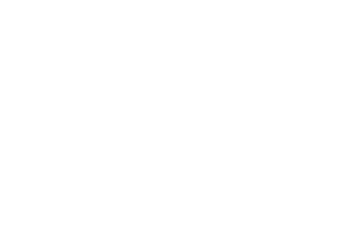

In [83]:
import matplotlib.patches as mpatches #legends

patch1 = mpatches.Patch(color='r', label='Socialdemokratiet')
patch2 = mpatches.Patch(color='b', label='Venstre')
patch3 = mpatches.Patch(color='pink', label='Dansk Folkeparti')
patch4 = mpatches.Patch(color='brown', label='Socialistisk Folkeparti')
patch5 = mpatches.Patch(color='#1f78b4', label='Radikale Venstre')
patch6 = mpatches.Patch(color='#00583C', label='Det Konservative Folkeparti')
patch7 = mpatches.Patch(color='#235d66', label='Nye Borgerlige')
patch8 = mpatches.Patch(color='#D0004D', label='Enhedslisten')
patch9 = mpatches.Patch(color='orange', label='Liberal Alliance')
patch10 = mpatches.Patch(color='green', label='Alternativet')
patch11 = mpatches.Patch(color='black', label='Government')
patch13 = mpatches.Patch(color='grey', label='unknown')

plt.axis('off')

100%|██████████| 2000/2000 [00:19<00:00, 100.24it/s]


BarnesHut Approximation  took  2.17  seconds
Repulsion forces  took  16.87  seconds
Gravitational forces  took  0.01  seconds
Attraction forces  took  0.21  seconds
AdjustSpeedAndApplyForces step  took  0.35  seconds


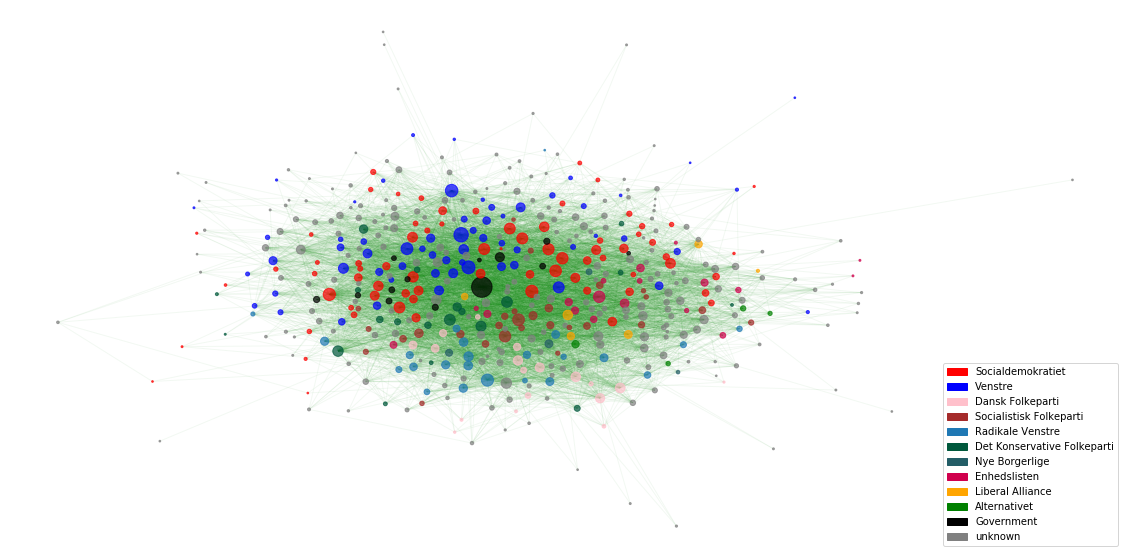

In [85]:
from fa2 import ForceAtlas2

forceatlas2 = ForceAtlas2(
                        # Behavior alternatives
                        outboundAttractionDistribution=False,  # Dissuade hubs   #Want hubs inside other!
                        linLogMode=False,  # NOT IMPLEMENTED
                        adjustSizes=False,  # Prevent overlap (NOT IMPLEMENTED)
                        edgeWeightInfluence=1.0,

                        # Performance
                        jitterTolerance=1.0,  # Tolerance
                        barnesHutOptimize=True,
                        barnesHutTheta=1.2,
                        multiThreaded=False,  # NOT IMPLEMENTED

                        # Tuning
                        scalingRatio=2.0,
                        strongGravityMode=True,
                        gravity=1.0,

                        # Log
                        verbose=True)


positions = forceatlas2.forceatlas2_networkx_layout(giant, pos=None, iterations=2000)

plt.figure(figsize=(20,10))
nx.draw_networkx_nodes(giant, positions, node_color=color_map, alpha=0.7,node_size=[v * 1 for v in d.values()])
nx.draw_networkx_edges(giant, positions, edge_color="green", alpha=0.05)
plt.legend(handles=[patch1,patch2,patch3,patch4,patch5,patch6,patch7,patch8,patch9,patch10,patch11,patch13])

plt.axis('off')
plt.show()

## Observations
The graph is quite compact, with many large blue and red nodes which makes sense, as these are the biggest parties in denmark; namely "Venstre" and "Socialdemokratiet". Furthermore, there are large black nodes that are central in the network - this also makes sense as we've marked government entities as black. However there are still some problems with the visualization that we want to solve.


# Segregating into red block vs blue block

The problem with the network visualization is that we have too many different parties and getting a nice visualization becomes difficult. Bloc politics refers to the act of parties uniting in order to gain a majority vote over the parliament. In danish politics, according to https://da.wikipedia.org/wiki/Blokpolitik we have 3 blocs, red blue and green. We will segregate our parties into this by adding a graph attribute "bloc" .

In [23]:
red_bloc = ['Socialdemokratiet', 'Enhedslisten', 'Socialistisk Folkeparti', 'Radikale Venstre']
blue_bloc = ['Venstre', 'Dansk Folkeparti', 'Det Konservative Folkeparti', 'Liberal Alliance', 'Nye Borgerlige', 'Fremad']
green_bloc = ['Alternativet']
    
    
for key, val in dict_of_attributes.items():
    print(key)
    if val['party'] in red_bloc:
        val['block'] = 'red'
    elif val['party'] in blue_bloc:
        val['block'] = 'blue'
    elif val['party'] in green_bloc:
        val['block'] = 'green'
    elif val['party'] == 'Government':
        val['block'] = 'black'
    else: 
        val['block'] = 'white' # white node means unknown
        
nx.set_node_attributes(G, dict_of_attributes)

Gcc = sorted(nx.weakly_connected_components(G), key=len, reverse=True)

giant = G.subgraph(Gcc[0])
giant = giant.to_undirected()
d = dict(giant.degree) #degrees for every node

for node in list(giant.nodes()):
    if (giant.degree(node) <= 2):
        giant.remove_node(node)

block_color_map = list(nx.get_node_attributes(giant, 'block').values())
print(block_color_map)

vestager
SchaldemoseMEP
karmel80
oestergaard
sofiecn
simonkollerup
jesper_bedreby
RohlChristopher
larsloekke
Statsmin
_MaiMercado
JakobEllemann
SorenPape
RasmusJarlov
BjBrandenborg
Kristianthdahl
Jesper_Pet
rasmusnordqvist
FrankJensenKBH
LouiseElholm
JanEJoergensen
RStoklund
regeringDK
LotteRod
aahlers
PiaOlsen
signe_munk
PSkipperEL
MaiVilladsen
rubenkidde
DanJoergensen
NWammen
FrkCallesen
SamiraNawa
a_steenberg
stinuslindgreen
karinFbach
KatrineRobsoe
martinlidegaard
metteabildgaard
olebirkolesen
Hans_Kr_Skibby
LeaWermelin
mortenhelveg
Joymogensen
SandKjaer
orlaosterby
Sten_Knuth
BirgitteBergman
brittbager
zeniastampe
JeppeBruus
mattiastesfaye
RosenkrantzT
KHegaard
krarup_lars
Pia_Kjaersgaard
pederhvelplund
MogensJensenS
RosaLundEl
EvaFlyvholm
JakobSoelvhoej
AndersKronborg
nvillumsen
StemLAURITZEN
mfMorten
RuneLundEL
Heunicke
karinaehl
Danielpanduro
mariagudme
PHummelgaard
VictoriaRV
uffeelbaek
IdaAuken
Paulin_Anne
larsgaardhoj
skaarup_df
MargreteAuken
ammitzbollbille
MrMesserschmidt


100%|██████████| 2000/2000 [00:20<00:00, 96.15it/s] 


BarnesHut Approximation  took  2.10  seconds
Repulsion forces  took  17.78  seconds
Gravitational forces  took  0.01  seconds
Attraction forces  took  0.21  seconds
AdjustSpeedAndApplyForces step  took  0.37  seconds


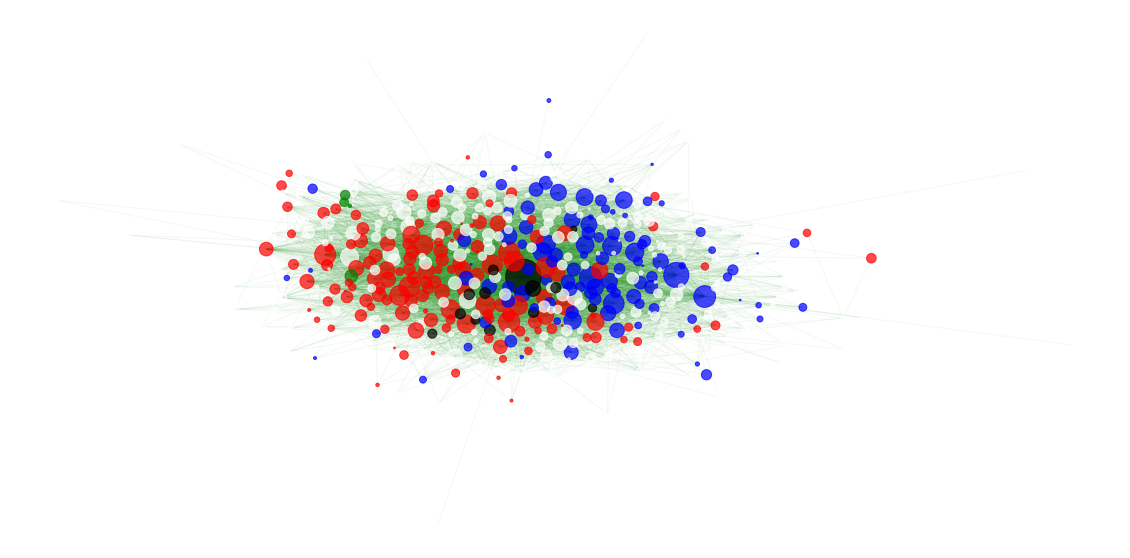

In [24]:
from fa2 import ForceAtlas2

forceatlas2 = ForceAtlas2(
                        # Behavior alternatives
                        outboundAttractionDistribution=False,  # Dissuade hubs   #Want hubs inside other!
                        linLogMode=False,  # NOT IMPLEMENTED
                        adjustSizes=False,  # Prevent overlap (NOT IMPLEMENTED)
                        edgeWeightInfluence=1.0,

                        # Performance
                        jitterTolerance=1.0,  # Tolerance
                        barnesHutOptimize=True,
                        barnesHutTheta=1.2,
                        multiThreaded=False,  # NOT IMPLEMENTED

                        # Tuning
                        scalingRatio=2.0,
                        strongGravityMode=True,
                        gravity=1.0,

                        # Log
                        verbose=True)


positions = forceatlas2.forceatlas2_networkx_layout(giant, pos=None, iterations=2000)

plt.figure(figsize=(20,10))
nx.draw_networkx_nodes(giant, positions, node_color=block_color_map, alpha=0.7,node_size=[v * 3 for v in d.values()])
nx.draw_networkx_edges(giant, positions, edge_color="green", alpha=0.05)
plt.axis('off')
plt.show()

Now we can observe some seperation between the red and blue blocs, with government entities in the middle (black nodes)

Let's try to eliminate the white ('UNKNOWNS')

In [25]:
for node in list(giant.nodes(data=True)):
    if (node[1]['block'] == 'white'):
        giant.remove_node(node[0])
block_color_map = list(nx.get_node_attributes(giant, 'block').values())
d = dict(giant.degree) #degrees for every node

print(block_color_map)

['red', 'red', 'red', 'red', 'red', 'blue', 'blue', 'blue', 'blue', 'blue', 'blue', 'red', 'blue', 'red', 'red', 'blue', 'blue', 'red', 'black', 'red', 'blue', 'red', 'red', 'red', 'red', 'red', 'red', 'red', 'red', 'red', 'red', 'red', 'red', 'blue', 'blue', 'blue', 'red', 'red', 'red', 'blue', 'blue', 'blue', 'red', 'red', 'red', 'red', 'red', 'blue', 'red', 'red', 'red', 'red', 'red', 'red', 'red', 'blue', 'red', 'red', 'red', 'red', 'red', 'red', 'red', 'red', 'blue', 'red', 'blue', 'red', 'blue', 'blue', 'blue', 'red', 'blue', 'blue', 'blue', 'blue', 'blue', 'blue', 'red', 'red', 'blue', 'blue', 'red', 'red', 'red', 'red', 'red', 'red', 'blue', 'red', 'black', 'black', 'blue', 'blue', 'red', 'blue', 'red', 'blue', 'red', 'blue', 'red', 'red', 'blue', 'red', 'red', 'blue', 'blue', 'green', 'red', 'red', 'red', 'red', 'red', 'red', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'red', 'black', 'black', 'blue', 'blue', 'blue', 'red', 'red', 'blue', 'red', 'blue', 'red

100%|██████████| 2000/2000 [00:07<00:00, 278.27it/s]


BarnesHut Approximation  took  0.75  seconds
Repulsion forces  took  5.97  seconds
Gravitational forces  took  0.01  seconds
Attraction forces  took  0.12  seconds
AdjustSpeedAndApplyForces step  took  0.20  seconds


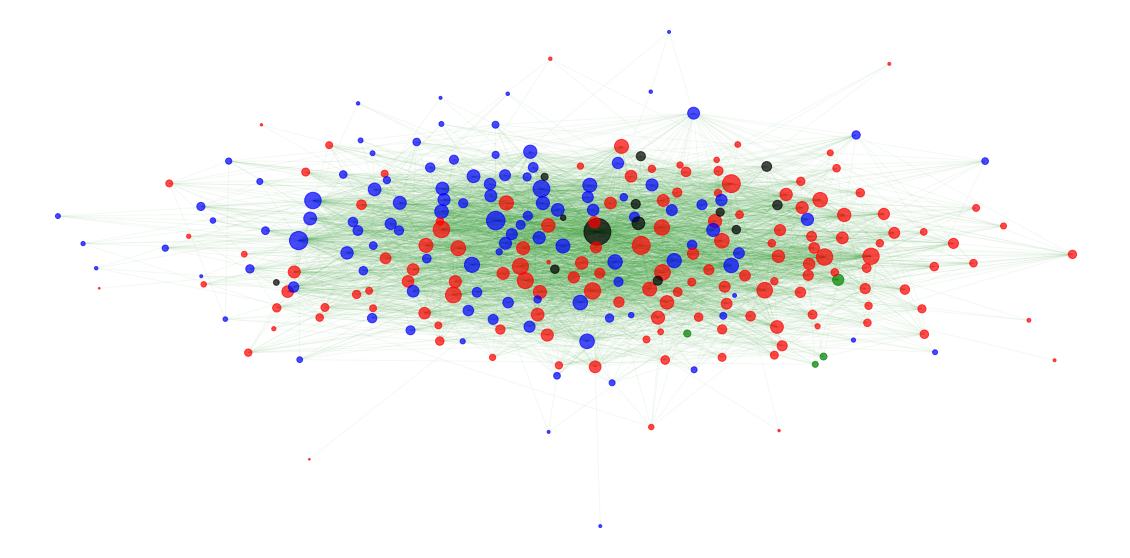

In [26]:
forceatlas2 = ForceAtlas2(
                        # Behavior alternatives
                        outboundAttractionDistribution=False,  # Dissuade hubs   #Want hubs inside other!
                        linLogMode=False,  # NOT IMPLEMENTED
                        adjustSizes=False,  # Prevent overlap (NOT IMPLEMENTED)
                        edgeWeightInfluence=1.0,

                        # Performance
                        jitterTolerance=1.0,  # Tolerance
                        barnesHutOptimize=True,
                        barnesHutTheta=1.2,
                        multiThreaded=False,  # NOT IMPLEMENTED

                        # Tuning
                        scalingRatio=2.0,
                        strongGravityMode=True,
                        gravity=1.0,

                        # Log
                        verbose=True)


positions = forceatlas2.forceatlas2_networkx_layout(giant, pos=None, iterations=2000)

plt.figure(figsize=(20,10))
nx.draw_networkx_nodes(giant, positions, node_color=block_color_map, alpha=0.7,node_size=[v * 3 for v in d.values()])
nx.draw_networkx_edges(giant, positions, edge_color="green", alpha=0.05)
plt.axis('off')
plt.show()

The network looks a bit neater, but we can observe that the large central government profiles have decreased in degree, signalling that a lot of the unknowns have tweeted to that profile. Interestingly, the few green block nodes are leaning to the right. Now we will look at sentiment of tweets, that link 2 profiles.

### Sentiment

We want to analyze the sentiment score that the tweets have associated to them, moreover we want to get an idea of how cross party tweets are scored. This could for example, show that a certain party may agree more, on average than an other party, would this be as expected regarding the block politics we've described earlier? This is what we look to find out

In [27]:
#!pip install afinn
#!pip install langdetect

from langdetect import detect
from afinn import Afinn
afinn = Afinn()
afinn_da = Afinn(language='da')

In [28]:
with open('tweet_dict_listversion_wrealnames_v2.data', 'rb') as filehandle:
    tweet_dict = pickle.load(filehandle) 

In [29]:
# helper function
def get_party(node):
    # returns party of a node
    x = data.loc[data['Twittername'] == node]    
    for w in x['Party']: # returns one item couldn't do x['Party'][0] for some reason
        return w



In [30]:
total_sentiment = dict.fromkeys(unique_parties)
for key, value in total_sentiment.items():
    total_sentiment[key] = { i : {'scores':[], 'mean': 0} for i in unique_parties }


In [31]:
# for each tweet calculate a score 
# get from party and to party
# update total
count = 0

for key,value in tqdm(tweet_dict.items()):
    #print(key)
    from_party = get_party(key)
    for mention, texts in value.items():
        to_party = get_party(mention)
        for tweet in texts:
            # remove @s
            tweet = re.sub(r'@\w+\b', '', tweet)
            tweet = tweet.strip()
            try:
                lang = detect(tweet)
            except Exception as e:
                #print(e)
                #print("tweet = " + tweet)
                continue # skip
            if lang == 'da':
                score = afinn_da.score(tweet)
            elif lang == 'en':
                score = afinn.score(tweet)
            else:
                score = afinn_da.score(tweet)
                #print(tweet)
                #print("Language    " + lang)
                #print("debug: " + str(afinn_da.score(tweet)))
                continue

            try:
                total_sentiment[from_party][to_party]['scores'].append(score)
            except Exception as e:
                continue
                #print("Error" + str(e))
                #print("Backlog: ")
                #print("tweet from "  + key + " to " + mention)


### Party alliances

We've now added sentiment scores for all the politician's tweets to other politicians. So let's check out how some of the sentiment is looking and break it down into parties

In [32]:
def isNaN(num):
    return num != num

In [33]:
for f, _to in total_sentiment.items():
    for key in _to.keys():
        mean = np.nanmean(total_sentiment[f][key]['scores'])
        # when no mentions to a party set default 0
        if isNaN(mean):
            #print(f, _to)
            mean = 0
        #print(mean)
        total_sentiment[f][key]['mean'] = mean

C:\Users\Christian\anaconda3\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: Mean of empty slice
  This is separate from the ipykernel package so we can avoid doing imports until


In [34]:
for key, value in total_sentiment.items():
    sorted_list = sorted(value.items(), key=lambda k_v: k_v[1]['mean'])
    #print(sorted_list)
    sorted_list.reverse()
    print(key + " is most positive regarding " +  str(sorted_list[0][0]) + ":"+ str(sorted_list[0][1]['mean']))

Alternativet is most positive regarding Radikale Venstre:3.3333333333333335
UNKNOWN is most positive regarding Inuit Ataqatigiit:4.0
Socialistisk Folkeparti is most positive regarding UNKNOWN:1.2102564102564102
Det Konservative Folkeparti is most positive regarding Venstre:1.5904761904761904
Dansk Folkeparti is most positive regarding Det Konservative Folkeparti:1.3269230769230769
Government is most positive regarding Socialistisk Folkeparti:1.6666666666666667
Nye Borgerlige is most positive regarding Venstre:1.3703703703703705
Inuit Ataqatigiit is most positive regarding Enhedslisten:3.5
Radikale Venstre is most positive regarding Inuit Ataqatigiit:8.0
Liberal Alliance is most positive regarding Radikale Venstre:1.4545454545454546
Venstre is most positive regarding Radikale Venstre:2.0625
Enhedslisten is most positive regarding Dansk Folkeparti:1.1764705882352942
Uden for folketingsgrupperne is most positive regarding Nye Borgerlige:3.0
Socialdemokratiet is most positive regarding Alt

In [35]:
for key, value in total_sentiment.items():
    sorted_list = sorted(value.items(), key=lambda k_v: k_v[1]['mean'])
    n = len(sorted_list)

    #print(sorted_list)
    sorted_list.reverse()
    print(key + " is most negative regarding " +  str(sorted_list[n-1][0]) + ":"+ str(sorted_list[n-1][1]['mean']))

Alternativet is most negative regarding Government:-0.0967741935483871
UNKNOWN is most negative regarding Nye Borgerlige:-0.41025641025641024
Socialistisk Folkeparti is most negative regarding Nye Borgerlige:-0.8571428571428571
Det Konservative Folkeparti is most negative regarding Nye Borgerlige:-1.0
Dansk Folkeparti is most negative regarding Government:-0.6103896103896104
Government is most negative regarding Enhedslisten:-0.5
Nye Borgerlige is most negative regarding Socialistisk Folkeparti:-2.3333333333333335
Inuit Ataqatigiit is most negative regarding Socialdemokratiet:-4.0
Radikale Venstre is most negative regarding Nye Borgerlige:-0.6666666666666666
Liberal Alliance is most negative regarding Uden for folketingsgrupperne:-1.3333333333333333
Venstre is most negative regarding Inuit Ataqatigiit:0
Enhedslisten is most negative regarding Nye Borgerlige:-1.6
Uden for folketingsgrupperne is most negative regarding Government:-0.32941176470588235
Socialdemokratiet is most negative re

### Analysis of cross party relationships
Recall our block segmentation


In [36]:
print("blues: " + str(blue_bloc))
print("reds: " + str(red_bloc))

blues: ['Venstre', 'Dansk Folkeparti', 'Det Konservative Folkeparti', 'Liberal Alliance', 'Nye Borgerlige', 'Fremad']
reds: ['Socialdemokratiet', 'Enhedslisten', 'Socialistisk Folkeparti', 'Radikale Venstre']


The results are a bit mixed, we see dansk folkeparti agreeing the most with det konservative, and det konservative to venstre as these are all blue block members, however enhedslisten agrees most with Radikale, which is not the same block. Same thing can be said for Venstre -> Radikale and Liberal -> Radikale. This could suggest that the current block politic strategy might be a bit flawed. However it must also be considered that there are a lot of unknown parties so the truth could be burried in decrypting this data.



14


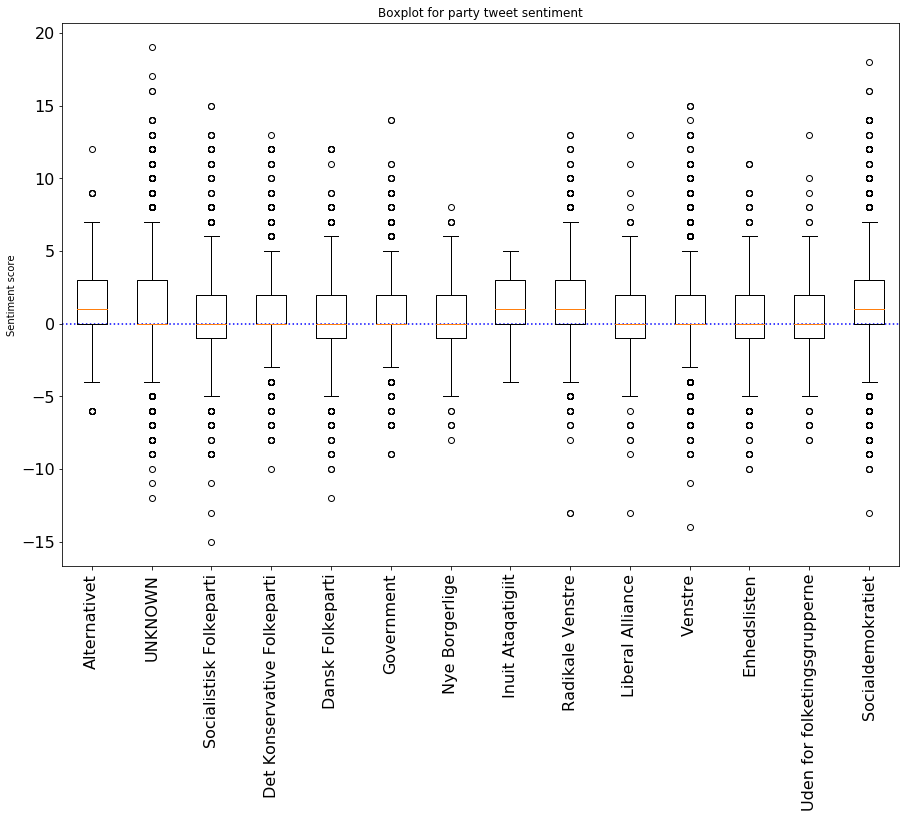

In [49]:
# for each party get statistics and make plot
box_labels = []
_scores = []

for key, value in total_sentiment.items():
    box_labels.append(key)
    score_l = []
    for inner in value.values():
        score = inner['scores']
        #print(score)
        score_l.extend(score)
    _scores.append(score_l)
print(len(_scores))
#The results are a bit mixed, we see dansk folkeparti agreeing the most with det konservative, and det konservative to venstre as these are all blue block members, however enhedslisten agrees most with Radikale, which is not the same block. Same thing can be said for Venstre -> Radikale and Liberal -> Radikale. This could suggest that the current block politic strategy might be a bit flawed. However it must also be considered that there are a lot of unknown parties so the truth could be burried in decrypting this data.


#print((_scores))

fig = plt.subplots(figsize=(15,10))
plt.tick_params(labelsize=16)
plt.xticks(rotation=90)
plt.ylabel('Sentiment score')
plt.title("Boxplot for party tweet sentiment")
plt.boxplot(_scores, labels=box_labels)
plt.hlines(0, 0.5, 14.5, linestyles='dotted', color='blue')
plt.show()



#### Plotting a relationship graph

In [38]:
from fa2 import ForceAtlas2


100%|██████████| 2000/2000 [00:00<00:00, 28545.59it/s]


BarnesHut Approximation  took  0.03  seconds
Repulsion forces  took  0.02  seconds
Gravitational forces  took  0.00  seconds
Attraction forces  took  0.00  seconds
AdjustSpeedAndApplyForces step  took  0.01  seconds
196


C:\Users\Christian\anaconda3\lib\site-packages\ipykernel_launcher.py:54: UserWarning: Requested projection is different from current axis projection, creating new axis with requested projection.


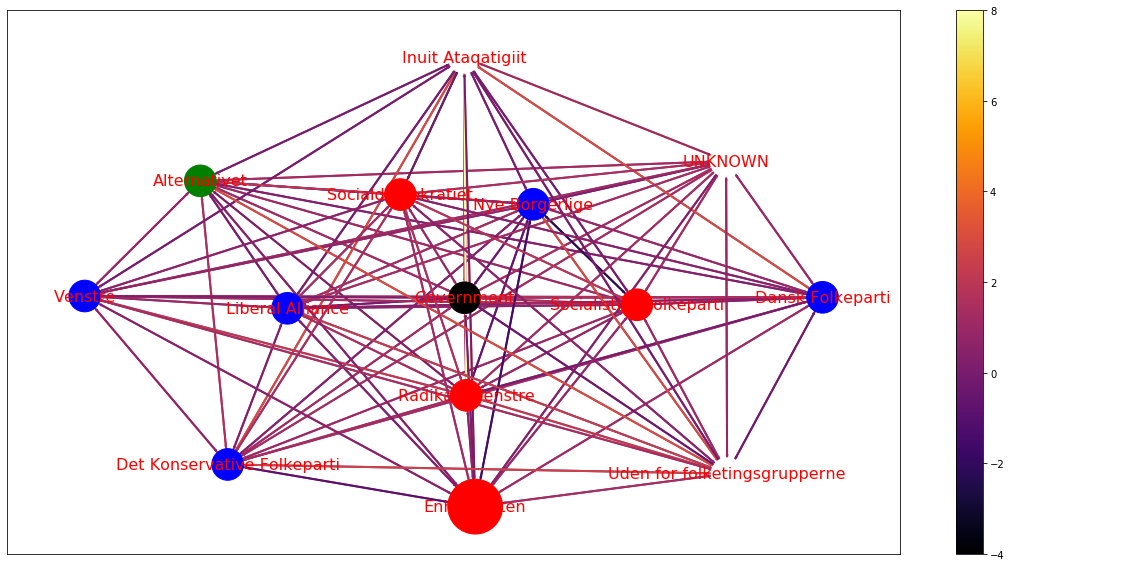

In [39]:
import matplotlib as mpl
G_friends =  G = nx.DiGraph()
# adding edges with weights according to sentiment 
for node in total_sentiment.keys():
    for _node in total_sentiment[node].keys():
        G.add_edge(node, _node)

plt.figure(figsize=(20,10))

pos = forceatlas2.forceatlas2_networkx_layout(G_friends, pos=None, iterations=2000)
M = G.number_of_edges()
print(M)
node_sizes = [1000 for x in range(len(G.nodes))]
node_sizes[11] = 3000
colors_friends = []
#### Plotting a relationship grap
node_color_friends = []
for node in G.nodes():
    if node in blue_bloc:
        node_color_friends.append('blue')
    elif node in red_bloc:
        node_color_friends.append('red')
    elif node in green_bloc:
        node_color_friends.append('green')
    elif node == 'Government':
        node_color_friends.append('black')
    else:
        node_color_friends.append('white')

for key, val in total_sentiment.items():
    for score in val.values():
        colors_friends.append(score['mean']) 
nodes = nx.draw_networkx_nodes(G, pos, node_size=node_sizes, with_labels = True, node_color=node_color_friends)
edges = nx.draw_networkx_edges(
    G,
    pos,
    node_size=node_sizes,
    arrowstyle="->",
    arrowsize=2,
    edge_color=colors_friends,
    edge_cmap=plt.cm.inferno,
    width=2,
)
labels = {}    
for node in G.nodes():
    labels[node] = node

nx.draw_networkx_labels(G,pos,labels,font_size=16,font_color='r')

pc = mpl.collections.PatchCollection(edges, cmap=plt.cm.inferno)
pc.set_array(colors_friends)

plt.colorbar(pc)
ax = plt.gca(label='Score')
ax.set_axis_off()
plt.ylabel('Score')
plt.show()

In [40]:
colors_friends_gov_out = []
for score in total_sentiment['Government'].values():
        colors_friends_gov_out.append(score['mean']) 
G_gov_out = nx.Graph()
for _node in total_sentiment['Government'].keys():
    G_gov_out.add_edge('Government', _node)

node_color_friends = []
for node in G.nodes():
    if node in blue_bloc:
        node_color_friends.append('blue')
    elif node in red_bloc:
        node_color_friends.append('red')
    elif node in green_bloc:
        node_color_friends.append('green')
    elif node == 'Government':
        node_color_friends.append('black')
    else:
        node_color_friends.append('white') 

100%|██████████| 2000/2000 [00:00<00:00, 28143.46it/s]

BarnesHut Approximation  took  0.02  seconds
Repulsion forces  took  0.03  seconds
Gravitational forces  took  0.00  seconds
Attraction forces  took  0.00  seconds
AdjustSpeedAndApplyForces step  took  0.02  seconds


ValueError: Invalid RGBA argument: 1.3373493975903614

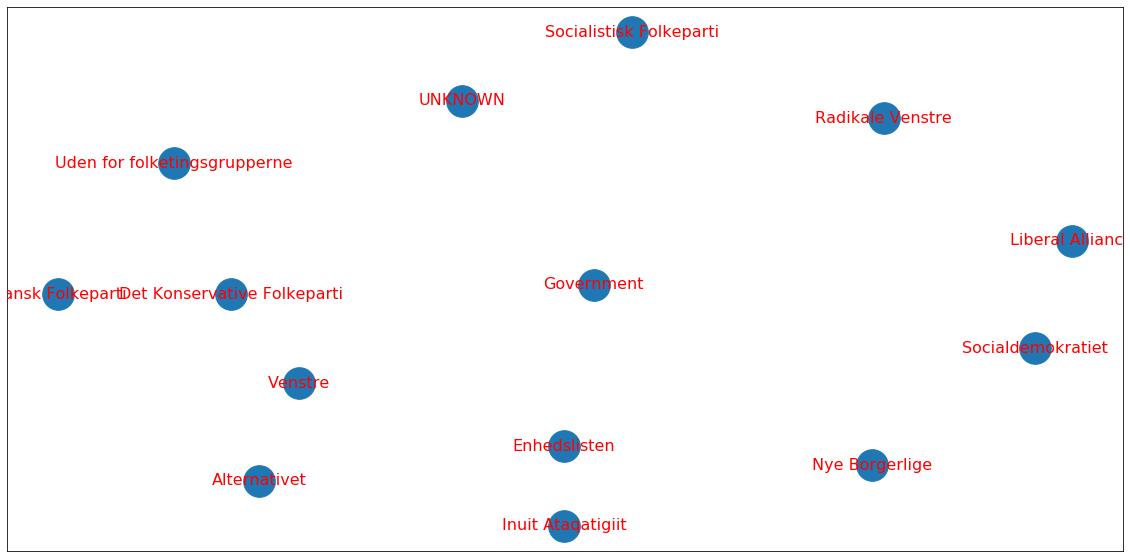

In [41]:
plt.figure(figsize=(20,10))

pos = forceatlas2.forceatlas2_networkx_layout(G_gov_out, pos=None, iterations=2000)
nodes = nx.draw_networkx_nodes(G_gov_out, pos, node_size=1000, with_labels = True, node_colors=node_color_friends)
labels = {}    
for node in G_gov_out.nodes():
    labels[node] = node

nx.draw_networkx_labels(G_gov_out,pos,labels,font_size=16,font_color='r')
edges = nx.draw_networkx_edges(
    G_gov_out,
    pos,
    edge_color=colors_friends,
    edge_cmap=plt.cm.inferno,
    width=2,
)

pc = mpl.collections.PatchCollection(edges, cmap=plt.cm.inferno)
pc.set_array(colors_friends)

plt.colorbar(pc)
ax = plt.gca(label='Score')
ax.set_axis_off()
plt.ylabel('Score')
plt.show()
plt.show()

In [ ]:
colors_friends_gov_out

In [ ]:
(colors_friends_gov_out)

In [ ]:
G_gov_out.edges()